# Assignment 1

Karolina Chlopicka, 15716546
Shania Sinha, 14379031

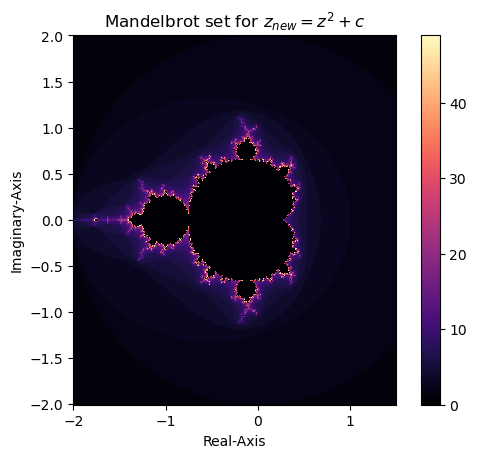

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# setting parameters (these values can be changed)
xDomain, yDomain = np.linspace(-2,1.5,500), np.linspace(-2,2,500)
bound = 2
power = 2             # any positive floating point value
max_iterations = 50   # any positive integer value
colormap = 'magma'    # set to any matplotlib valid colormap


# computing 2-d array to represent the mandelbrot-set
iterationArray = []
for y in yDomain:
    row = []
    for x in xDomain:
        c = complex(x,y)
        z = 0
        for iterationNumber in range(max_iterations):
            if(abs(z) >= bound):
                row.append(iterationNumber)
                break
            else: z = z**power + c
        else:
            row.append(0)

    iterationArray.append(row)

# plotting the data
ax = plt.axes()
#plt.rc('text', usetex = True)   # uncomment this line to enable use of tex when LaTeX is installed
ax.set_aspect('equal')
graph = ax.pcolormesh(xDomain, yDomain, iterationArray, cmap = colormap)
plt.colorbar(graph)
plt.xlabel("Real-Axis")
plt.ylabel("Imaginary-Axis")
plt.title('Mandelbrot set for $z_{{new}} = z^{{{}}} + c$'.format(power))
plt.show()

Investigating the area of the Mandelbrot set $A_M$ using Monte Carlo integration. $A_i,_s$ denotes an estimate of an area, where i refers to a number of iterations and s to a number of samples drawn.  

In [3]:

def check_mandelbrot(x,y):
    c = complex(x,y)
    z = 0
    for j in range(100):
        if(abs(z) >= bound):
            answer = 0
            break
        else: z = z**2 + c
    else:
        answer = 1
    return(answer)        

def monte_carlo(i,s):
    iterations = i #number of iterations
    sample_size = s #number of samples 
    size_iterations = np.zeros(iterations)

    for j in range(iterations):
        
        point_in = np.zeros(sample_size) #storing the points that are inside the Mandelbrot set
        point_out = np.zeros(sample_size) #storing the points that are outside Mandelbrot set
        
        for i in range(sample_size):
        #generating number of point equivalent to the sample size within the rectagle. X in (-2,1.5) and Y in (-2,2)
            x_cordinate = np.random.uniform(-2,1.5) 
            y_cordinate = np.random.uniform(-2,2)

            if(check_mandelbrot(x_cordinate,y_cordinate)==1):
                point_in[i] = 1
            
            else: 
                point_out[i] = 1

        size = (np.count_nonzero(point_in == 1)/sample_size)*(3.5*4)
        size_iterations[j] = size   
    average_size = np.mean(size_iterations)  
    #return (f"For {i} iternations and sample size equal to {s} $A_i_s$ = {average_size}")
    return(average_size)

In [4]:
monte_carlo(100,10000)

1.5511019999999995

Convergence of $A_i,_s$ $\rightarrow$ $A_M$. We set a sample size to $s=1000$, and investigate the convergence of the area when changing the number of iterations. 

In [12]:
number_of_iterations = np.array([100*i for i in range(1,31)])
estimation = np.zeros(len(number_of_iterations)) #array to store the results of estimated area 

for i in range(len(number_of_iterations)):   
    iterations = number_of_iterations[i]   
    estimation[i] = monte_carlo(iterations,1000)
print(estimation)  


[1.55456    1.54749    1.54042    1.53993    1.550892   1.55325333
 1.55108    1.54049    1.53729333 1.549282   1.54448    1.54555333
 1.54742    1.5471     1.54944533 1.54424375 1.54799647 1.54497
 1.54871684 1.544851   1.54752667 1.54985727 1.54600783 1.54824833
 1.5419992  1.55187308 1.54637259 1.54901    1.54780138 1.55165733]


Text(0, 0.5, 'Difference in the estimated area: |A(i,1000) - A(3000,1000)|')

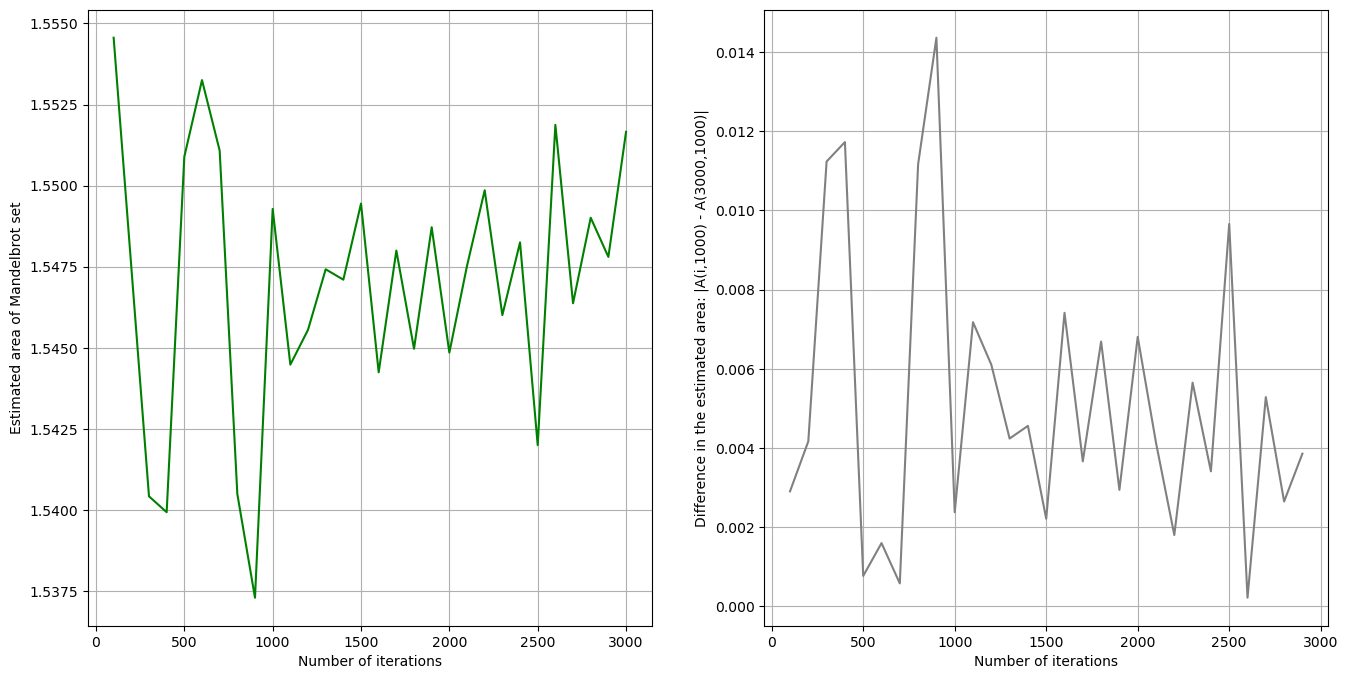

In [38]:
figure_1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(number_of_iterations,estimation, color = "green")
ax1.set_xlabel("Number of iterations")
ax1.set_ylabel("Estimated area of Mandelbrot set")
ax1.grid(True)
ax2.grid(True)

max_i = estimation[-1]
difference = np.abs(estimation[0:-1] - max_i)
ax2.plot(number_of_iterations[0:-1],difference, color = "grey")
ax2.set_xlabel("Number of iterations")
ax2.set_ylabel("Difference in the estimated area: |A(i,1000) - A(3000,1000)|")

